## やっていること
* bass_lineファイルの読み込み
* 各log.txtのparse => csvファイルに書き出し
* log.csv の読み込み => 結合してlog_dfを作成
* base_line, log_df にtime_GPSからtime_UTCを作成
* deriverd.csvを結合してdfとして保存(time_UTC付加)
* ground_truth.csv を結合してdfとして保存(time_UTC付加)

In [1]:
using DataFrames
using DataFramesMeta
using CategoricalArrays
using Pipe
using JLD2
using Dates
using LeapSeconds
using Combinatorics
using Random
using Statistics
using Profile
using ProgressMeter
# using Base.Threads
using CSV
using Glob
using Formatting
using DelimitedFiles
using TextAnalysis
using BenchmarkTools
ENV["COLUMNS"]=700;

"""
import Libdl
push!(Libdl.DL_LOAD_PATH, "/home/yuri/julia-1.5.0/LightGBM-3.2.0")
LIGHTGBM_SOURCE = abspath("/home/yuri/julia-1.5.0/LightGBM-3.2.0")
using LightGBM
using Flux
"""


"import Libdl\npush!(Libdl.DL_LOAD_PATH, \"/home/yuri/julia-1.5.0/LightGBM-3.2.0\")\nLIGHTGBM_SOURCE = abspath(\"/home/yuri/julia-1.5.0/LightGBM-3.2.0\")\nusing LightGBM\nusing Flux\n"

In [3]:
using PyPlot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 6
rcParams["figure.figsize"] = [16,16]
rcParams["figure.dpi"] = 220
plt.style.use("seaborn-darkgrid");

# baselineファイル

In [130]:
train_df = CSV.read("../baseline_locations_train.csv", DataFrame)
test_df = CSV.read("../baseline_locations_test.csv", DataFrame)
sample_sub_df =  CSV.read("../sample_submission.csv", DataFrame)

first(train_df, 5) |> display
first(test_df, 5) |> display
first(sample_sub_df, 5) |> display

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone
,String,String,Int64,Float64,Float64,Float64,String
1,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.4236,-122.094,-34.06,2020-05-14-US-MTV-1_Pixel4
2,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.4236,-122.094,-33.29,2020-05-14-US-MTV-1_Pixel4
3,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.4236,-122.094,-30.99,2020-05-14-US-MTV-1_Pixel4
4,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.4236,-122.094,-32.83,2020-05-14-US-MTV-1_Pixel4
5,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.4236,-122.094,-34.49,2020-05-14-US-MTV-1_Pixel4


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone
,String,String,Int64,Float64,Float64,Float64,String
1,2020-05-15-US-MTV-1,Pixel4,1273608785432,37.4166,-122.082,-30.69,2020-05-15-US-MTV-1_Pixel4
2,2020-05-15-US-MTV-1,Pixel4,1273608786432,37.4166,-122.082,-31.76,2020-05-15-US-MTV-1_Pixel4
3,2020-05-15-US-MTV-1,Pixel4,1273608787432,37.4167,-122.082,-31.65,2020-05-15-US-MTV-1_Pixel4
4,2020-05-15-US-MTV-1,Pixel4,1273608788432,37.4166,-122.082,-31.52,2020-05-15-US-MTV-1_Pixel4
5,2020-05-15-US-MTV-1,Pixel4,1273608789432,37.4166,-122.082,-28.95,2020-05-15-US-MTV-1_Pixel4


,phone,millisSinceGpsEpoch,latDeg,lngDeg
,String,Int64,Float64,Float64
1,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.9046,-86.4811
2,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.9046,-86.4811
3,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.9046,-86.4811
4,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.9046,-86.4811
5,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.9046,-86.4811


# parse gnss-logs -> CSV

In [58]:
function parse_float(str::SubString{String})::Float64
    str == "" && return NaN # catchに入ると5倍以上遅くなるので""の場合を分けておく
    try
        return parse(Float64, str)
    catch
        return NaN
    end
end

gnss_section_names = ["Raw","UncalAccel", "UncalGyro", "UncalMag", "Fix", "Status", "OrientationDeg"]
# from https://www.kaggle.com/sohier/loading-gnss-logs
function  gnss_log_to_dataframes(path::String, cname::String, pname::String)
    phone = "$(cname)_$(pname)"
    println("Loading $path"); flush(stdout)
    global datalines
    open(path, "r") do f
    datalines = readlines(f)
    end
    datas    = Dict([k => Array{Float64,1}([]) for k in gnss_section_names])
    gnss_map = Dict([k => Array{String,1}([]) for k in gnss_section_names])
    count = 0
    for (c, dataline) in enumerate(datalines)
        is_header = first(dataline) == '#'
        dataline = strip(dataline, ['#', ' ']) |> x -> split(x, ',')  |> collect
        # skip over notes, version numbers, etc
        section_name = dataline[1]
        ~(section_name in  gnss_section_names) && continue
        if is_header
            data = dataline[2:end]
            gnss_map[section_name] = data
        elseif ~(is_header)
            #print(dataline)
            n_col = length(gnss_map[section_name])
            data = parse_float.(dataline[2:end])
            if length(data) == n_col
                append!(datas[section_name], data)
            end
        end
    end
    
    results = Dict{String, DataFrame}()
    for k in keys(datas)
        n_col = length(gnss_map[k])
        n = length(datas[k])
        if n >0
            data = reshape(datas[k], (n_col, div(n, n_col))) |> transpose
            results[k] = DataFrame(data, Symbol.(gnss_map[k]))
        else
            results[k] = DataFrame()
        end
    end
    
    types = Dict{String, Array{DataType}}(
        "Raw" => [Int, Int, Float64,Float64, Int, Float64], 
        "UncalAccel"=>  [Int, Int, Float64,Float64, Float64], 
        "UncalGyro" =>  [Int, Int, Float64,Float64, Float64], 
        "UncalMag"  =>  [Int, Int, Float64,Float64, Float64], 
        "Fix"              => [],
        "Status"       =>  [Int, Int, Int,Int,Int,  Float64],
        "OrientationDeg" => [Int, Int]
        )
    display(results)
    for k in keys(results)
        for (i,(t, _)) in enumerate(zip(types[k], names(results[k])))
            results[k][!, i] = t.(results[k][!, i])
        end
        results[k][!, :collectionName] .= cname
        results[k][!, :phoneName] .= pname
        results[k][!, :phone] .= phone
    end
    
    # if col == "CodeType"
    return results
end
function build_gnss_log_dataframes(base_path::String)
    collection_names = readdir("../$base_path/")
    for (i, collection_name) in enumerate(collection_names)
        println("$i / $(length(collection_names))")
        phone_names = readdir("../$base_path/$collection_name")
        for phone_name in phone_names
            phone = "$(collection_name)_$(phone_name)"
            path= "../$base_path/$collection_name/$phone_name/"
            log_path = glob("*GnssLog.txt", path)[1]
            file_exist = true
            for gnss_section_name in gnss_section_names
                file_exist = (file_exist & isfile("../DataFrames/$(base_path)_$(phone)_$(gnss_section_name).csv"))
            end
            file_exist && println("pass");continue
            gnss_log_dict_ = gnss_log_to_dataframes(log_path, collection_name,phone_name)
            for gnss_section_name in gnss_section_names
                open("../DataFrames/$(base_path)_$(phone)_$(gnss_section_name).csv", "w") do io
                    CSV.write(io, gnss_log_dict_[gnss_section_name])
                end
                #append!(gnss_log_dict[gnss_section_name], gnss_log_dict_[gnss_section_name])
            end
        end
    end
    return 
end
gnss_log_dict = build_gnss_log_dataframes("train")
gnss_log_dict = build_gnss_log_dataframes("test")
#gnss_log_dfs = gnss_log_to_dataframes("../train/2020-07-08-US-MTV-1/Pixel4/Pixel4_GnssLog.txt", "2020-07-08-US-MTV-1", "Pixel4")

1 / 29
pass
pass
2 / 29
pass
pass
3 / 29
pass
4 / 29
pass
pass
5 / 29
pass
pass
pass
6 / 29
pass
pass
7 / 29
pass
pass
pass
8 / 29
pass
pass
pass
9 / 29
pass
pass
10 / 29
pass
pass
11 / 29
pass
pass
pass
12 / 29
pass
13 / 29
pass
14 / 29
pass
pass
15 / 29
pass
pass
pass
16 / 29
pass
pass
pass
17 / 29
pass
pass
pass
18 / 29
pass
pass
pass
pass
19 / 29
pass
pass
pass
pass
20 / 29
pass
pass
pass
pass
21 / 29
pass
pass
pass
22 / 29
pass
pass
23 / 29
pass
pass
pass
pass
24 / 29
pass
pass
25 / 29
pass
pass
26 / 29
pass
pass
pass
27 / 29
pass
pass
28 / 29
pass
pass
pass
29 / 29
pass
pass
1 / 20
2 / 20
pass
pass
3 / 20
pass
pass
4 / 20
pass
pass
pass
5 / 20
pass
pass
pass
6 / 20
pass
pass
pass
7 / 20
pass
pass
pass
8 / 20
pass
pass
pass
9 / 20
pass
pass
10 / 20
pass
pass
11 / 20
pass
pass
pass
12 / 20
pass
pass
pass
pass
pass
13 / 20
pass
pass
14 / 20
pass
pass
pass
pass
15 / 20
pass
pass
16 / 20
pass
17 / 20
pass
18 / 20
pass
pass
19 / 20
pass
pass
pass
20 / 20
pass
pass


In [111]:
function concat_log_data(base_path::String)::Dict{Symbol, DataFrame}
    logdf_dict = Dict{Symbol, DataFrame}()
    @showprogress for gnss_section_name in gnss_section_names
        fname = "*$(base_path)*$(gnss_section_name).csv"
        gnss_section_files =  glob(fname, "../DataFrames/")
        # @show(fname,gnss_section_files)
        df = DataFrame()
        for gnss_section_file in  gnss_section_files
            df_ = CSV.read(gnss_section_file, DataFrame)
            append!(df, df_, cols=:union)
        end
        for col in propertynames(df)
            x = df[!, col]
            T = nonmissingtype(eltype(x))
            if ismissing.(x) |> sum == 0
                df[!, col] =  T.(x)
            end
            if T == String
                df[!, col] =  categorical(x, compress=true)
            end
        end
        logdf_dict[Symbol(gnss_section_name)] = df
    end
    return logdf_dict
end

    
train_logdf_dict = concat_log_data("train")
test_logdf_dict = concat_log_data("test")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


Dict{Symbol,DataFrame} with 7 entries:
  :OrientationDeg => 3583787×8 DataFrame…
  :UncalMag       => 7987548×11 DataFrame…
  :Status         => 2936055×16 DataFrame…
  :Raw            => 2956220×39 DataFrame…
  :UncalGyro      => 15161421×11 DataFrame…
  :Fix            => 0×3 DataFrame
  :UncalAccel     => 15161424×11 DataFrame…

## UTC 時間を付加した上で保存しておく

In [8]:
function millisSinceGpsEpoch_to_UnixTime(millisSinceGpsEpoch::Int)::DateTime
    gps_utc0 = DateTime(1980, 1, 6)
    #うるう秒插入前
    tmp_t =  millisSinceGpsEpoch+ Int(datetime2unix(gps_utc0)) * 1000
    #うるう秒のせいでgps timeが進んでしまっているのを補正(utcはその分遅いので引く)
    t = tmp_t - (Int(offset_tai_utc(tmp_t)) - Int(offset_tai_utc(gps_utc0)))*1000
    return unix2datetime(t * 0.001)
end

function utcTimeMillis_to_UnixTime(utcTimeMillis::Int)::DateTime
    return unix2datetime(utcTimeMillis * 0.001)
end

function sort_column_order(df::DataFrame, col::Symbol, num::Int)::DataFrame
    col in propertynames(df) ? nothing : return df
    col_names = filter!(arr-> arr ≠col,propertynames(df))
    insert!(col_names, num, col)
    return df[!, col_names]
end

function add_time_UTC_logdf!(logdf_dict::Dict{Symbol, DataFrame})
    for gnss_section_name in gnss_section_names
        df = logdf_dict[Symbol(gnss_section_name)]
        :utcTimeMillis in propertynames(df) ? nothing : continue
        df[!, :time_UTC] = utcTimeMillis_to_UnixTime.(Int.(df.utcTimeMillis))
        n = length(propertynames(df))
        df = sort_column_order(df, :collectionName, 1)
        df = sort_column_order(df, :phoneName, 2)
        df = sort_column_order(df, :phone, 3)
        df = sort_column_order(df, :time_UTC, 4)
        df = sort_column_order(df, :utcTimeMillis, n)
        df = sort_column_order(df, :elapsedRealtimeNanos, n)
        logdf_dict[Symbol(gnss_section_name)] = df
    end
end

add_time_UTC_logdf!(train_logdf_dict)
add_time_UTC_logdf!(test_logdf_dict)

train_df[!, :time_UTC] = millisSinceGpsEpoch_to_UnixTime.(train_df.millisSinceGpsEpoch)
test_df[!, :time_UTC] = millisSinceGpsEpoch_to_UnixTime.(test_df.millisSinceGpsEpoch)
sample_sub_df[!, :time_UTC] = millisSinceGpsEpoch_to_UnixTime.(sample_sub_df.millisSinceGpsEpoch)

@save "../DataFrames/train_gnss_log.jdl2" train_logdf_dict
@save "../DataFrames/test_gnss_log.jdl2" test_logdf_dict

@save "../DataFrames/train_df.jdl2" train_df
@save "../DataFrames/test_df.jdl2" test_df
@save "../DataFrames/sample_sub_df.jdl2" sample_sub_df

LoadError: [91mUndefVarError: train_logdf_dict not defined[39m

In [1]:
for gnss_section_name in Symbol.(gnss_section_names)
    println(gnss_section_name)
    flush(stdout)
    display(first(train_logdf_dict[gnss_section_name], 10))
    flush(stdout)
end

LoadError: [91mUndefVarError: gnss_section_names not defined[39m

## derived.csvをDataFrameとして保存

In [2]:
function derived_to_dataframes(base_path::String)::DataFrame
    df = DataFrame()
    collection_names = readdir("../$base_path/")
    for collection_name in collection_names
        phone_names = readdir("../$base_path/$collection_name")
        for phone_name in phone_names
            phone = "$(collection_name)_$(phone_name)"
            path= "../$base_path/$collection_name/$phone_name/"
            derived_path = glob("*derived.csv", path)[1]
            df_ = CSV.read(derived_path, DataFrame)
            df_[!, :collectionName] .= collection_name
            df_[!, :phoneName] .= phone_name
            df_[!, :phone] .= phone
            append!(df, df_)
        end
    end
    df[!, :time_UTC] = millisSinceGpsEpoch_to_UnixTime.(df.millisSinceGpsEpoch)
    df = sort_column_order(df, :collectionName, 1)
    df = sort_column_order(df, :phoneName, 2)
    df = sort_column_order(df, :phone, 3)
    df = sort_column_order(df, :time_UTC, 4)
    return df
end
train_derived_df = derived_to_dataframes("train")
test_derived_df = derived_to_dataframes("test")

@save "../DataFrames/train_derived_df.jdl2" train_derived_df
@save "../DataFrames/test_derived_df.jdl2" test_derived_df

LoadError: [91mUndefVarError: millisSinceGpsEpoch_to_UnixTime not defined[39m

## ground_truth.csv をdataframeにする

In [6]:
function ground_truth_to_dataframes(base_path::String)::DataFrame
    df = DataFrame()
    collection_names = readdir("../$base_path/")
    for collection_name in collection_names
        phone_names = readdir("../$base_path/$collection_name")
        for phone_name in phone_names
            phone = "$(collection_name)_$(phone_name)"
            path= "../$base_path/$collection_name/$phone_name/"
            ground_truth_path = glob("*ground_truth.csv", path)[1]
            df_ = CSV.read(ground_truth_path, DataFrame)
            df_[!, :collectionName] .= collection_name
            df_[!, :phoneName] .= phone_name
            df_[!, :phone] .= phone
            append!(df, df_)
        end
    end
    df[!, :time_UTC] = millisSinceGpsEpoch_to_UnixTime.(df.millisSinceGpsEpoch)
    df = sort_column_order(df, :collectionName, 1)
    df = sort_column_order(df, :phoneName, 2)
    df = sort_column_order(df, :phone, 3)
    df = sort_column_order(df, :time_UTC, 4)
    return df
end

train_ground_truth_df = ground_truth_to_dataframes("train")
@save "../DataFrames/train_ground_truth_df.jdl2" train_ground_truth_df

LoadError: [91mUndefVarError: millisSinceGpsEpoch_to_UnixTime not defined[39m

In [13]:
# @show(Set(train_df[!, cname_col]) |> length)
# @show(Set(train_df[!, pname_col]) |> length)
display(combine(groupby(train_df, :collectionName), nrow))
display(combine(groupby(train_df, :phoneName), nrow))
#display(combine(groupby(train_df, [Symbol(cname_col), Symbol(pname_col)]), nrow))

,collectionName,nrow
,String,Int64
1,2020-05-14-US-MTV-1,3486
2,2020-05-14-US-MTV-2,2347
3,2020-05-21-US-MTV-1,2031
4,2020-05-21-US-MTV-2,3759
5,2020-05-29-US-MTV-1,5751
6,2020-05-29-US-MTV-2,4009
7,2020-06-04-US-MTV-1,5190
8,2020-06-05-US-MTV-1,5157
9,2020-06-05-US-MTV-2,3561


,phoneName,nrow
,String,Int64
1,Pixel4,48153
2,Pixel4XLModded,8388
3,Pixel4XL,27710
4,Mi8,14169
5,Pixel4Modded,6927
6,Pixel5,11791
7,SamsungS20Ultra,14204


In [ ]:
x 

In [85]:
function main()
    gnss_log_dfs["UncalAccel"][!, :time_UTC] =  unix2datetime.(gnss_log_dfs["UncalAccel"][!, :utcTimeMillis] /1000)
    train_df_ = train_df[train_df[!,:phone] .== "2020-05-14-US-MTV-1_Pixel4",:] 
    # derived_df[!, :time_UTC] = millisSinceGpsEpoch_to_UnixTime.(derived_df.millisSinceGpsEpoch);
    gnss_log_dfs["UncalAccel"] = @orderby(gnss_log_dfs["UncalAccel"], :time_UTC)
    @eachrow train_df_ begin
        @newcol UncalAccelXMps2::Array{Float64,1}
        @newcol UncalAccelYMps2::Array{Float64,1}
        @newcol UncalAccelZMps2::Array{Float64,1}
        :UncalAccelXMps2 = linear_interpolation(:time_UTC, gnss_log_dfs["UncalAccel"].time_UTC, gnss_log_dfs["UncalAccel"].UncalAccelXMps2)
        :UncalAccelYMps2 = linear_interpolation(:time_UTC, gnss_log_dfs["UncalAccel"].time_UTC, gnss_log_dfs["UncalAccel"].UncalAccelYMps2)
        :UncalAccelZMps2 = linear_interpolation(:time_UTC, gnss_log_dfs["UncalAccel"].time_UTC, gnss_log_dfs["UncalAccel"].UncalAccelZMps2)
    end
end
main()

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,time_UTC,UncalAccelXMps2,UncalAccelYMps2,UncalAccelZMps2
,String,String,Int64,Float64,Float64,Float64,String,DateTime,Float64,Float64,Float64
1,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.4236,-122.094,-34.06,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:45.442,0.705313,9.24103,1.36982
2,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.4236,-122.094,-33.29,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:46.442,0.00559685,10.2079,1.44794
3,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.4236,-122.094,-30.99,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:47.442,0.220563,9.92244,1.3182
4,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.4236,-122.094,-32.83,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:48.442,0.376296,9.62179,1.26855
5,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.4236,-122.094,-34.49,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:49.442,-0.015159,9.87013,0.896537
6,2020-05-14-US-MTV-1,Pixel4,1273529468442,37.4236,-122.094,-33.57,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:50.442,0.385191,9.43781,1.22964
7,2020-05-14-US-MTV-1,Pixel4,1273529469442,37.4236,-122.094,-33.52,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:51.442,0.110886,10.078,0.895518
8,2020-05-14-US-MTV-1,Pixel4,1273529470442,37.4236,-122.094,-31.6,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:52.442,0.603654,9.38596,1.11177
9,2020-05-14-US-MTV-1,Pixel4,1273529471442,37.4236,-122.094,-34.22,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:53.442,-0.0794304,10.158,0.997616


# nmeaデータの取得 => testセットにはないのでボツだが，derived.csvから緯度経度を作る際に役に立つかも

In [84]:
mutable struct GGA
    # nmeaデータからGGAを抜き出す
    system::String # GPS only
    time::DateTime # in UTC seconds
    latitude::Float64 # decimal degrees
    longitude::Float64 # decimal degrees
    num_sats::Int
    altitude::Float64 # MSL in meters
end

function parse_GGA(nmea_str::String, Date_str::String)::GGA
    # nmeaデータからGGAを抜き出す
    nmea_str[1:6] == "\$GPGGA" ? nothing : throw(AssertionError("Not GPGGA code"))
    df = dateformat"y-m-d-HHMMSS.ss"
    data = split(nmea_str, ',')
    datetime = DateTime(Date_str * data[2], df)
    #display(data)
    ps(x::SubString{String}) =  parse(Float64, x)
    acc = data[4][1] == 'N' ? 1.0 : -1.0
    latitude = (ps(data[3][1:end-10]) + ps(data[3][end-9:end])/60.0) * acc
    acc = data[6][1] == 'E' ? 1.0 : -1.0
    longitude = (ps(data[5][1:end-10]) + ps(data[5][end-9:end])/60.0) * acc
    
    return GGA("GPS", datetime, latitude, longitude, ps(data[8]), ps(data[10]))
end

function parse_nmea(nmea_path::String, phone_name::String)
    gga_data = []
    r_date = r"\d{4}-\d{2}-\d{2}-"
    r_collection = r"\d{4}-\d{2}-\d{2}-.*-.*-\d"
    m = match(r_date, nmea_path)
    date_str = String(m.match)
    m = match(r_collection, nmea_path)
    collection_name = String(m.match)
    open(nmea_path, "r") do f
        for line in eachline(f)
            line[1:6] == "\$GPGGA" ? nothing : continue
            gga = parse_GGA(line, date_str)
            push!(gga_data, gga)
        end
    end
    df = DataFrame(collectionName = collection_name,
                    phoneName = phone_name,
                    time_UTC=getfield.(gga_data, :time), 
                    latitude=getfield.(gga_data, :latitude), 
                    longitude=getfield.(gga_data, :longitude), 
                    num_sats=getfield.(gga_data, :num_sats), 
                    altitude=getfield.(gga_data, :altitude)
    )
    return df
end

function linear_interpolation(time_UTC::DateTime, time_UTC_arr::Array{DateTime,1}, data_arr::Array{Float64,1})::Float64
# function linear_interpolation(time_UTC::DateTime, time_UTC_arr::Array{DateTime,1}, data_arr::Array{Float64,1})::Float64
    sort_utc = sort(time_UTC_arr)
    # time_UTC_arr == sort_utc ? println(true) : throw(AssertionError("Not sorted"))
    idx0 = searchsortedlast(time_UTC_arr, time_UTC)
    idx1 = searchsortedfirst(time_UTC_arr, time_UTC)
    length(data_arr) < idx1 && return data_arr[idx0]
    idx0 == idx1 && return data_arr[idx0]
    
    time_delta = (time_UTC_arr[idx1] - time_UTC_arr[idx0]).value |> Float64
    time_delta0 = (time_UTC - time_UTC_arr[idx0]).value |> Float64
    time_delta1 = time_delta - time_delta0
    """
    @show(idx0, idx1, time_delta, time_delta0, time_delta1, data_arr[idx0], data_arr[idx1])
    @show(time_UTC, time_UTC_arr[idx0], time_UTC_arr[idx1])
    println("=========================================")
    """
    res = (data_arr[idx0] * time_delta1 + data_arr[idx1] * time_delta0) / time_delta
    isnan(res) ? throw(AssertionError("time_UTC: $time_UTC, idx0: $idx0, idx1: $idx1, time_delta: $time_delta")) : nothing
    return (data_arr[idx0] * time_delta1 + data_arr[idx1] * time_delta0) / time_delta
end

function interpolate_Lat(time_UTC_arr)
    latitude_arr = zeros(size(time_UTC_arr,1))
    longitude_arr = zeros(size(time_UTC_arr,1))
    for (i, t) in enumerate(time_UTC_arr)
        latitude_arr[i] = linear_interpolation(t, nmea_df.time_UTC, nmea_df.latitude)
        longitude_arr[i] = linear_interpolation(t, nmea_df.time_UTC, nmea_df.longitude)
    end
    return latitude_arr, longitude_arr
end
"""
# TEST
nmea_str = String("\$GPGGA,220134.00,3725.4168121,N,12205.6498009,W,1,14,1.0,2.70,M,-32.64,M,,*53")
path = "../train/2020-05-14-US-MTV-1/Pixel4/supplemental/SPAN_Pixel4_10Hz.nmea"
nmea_df = parse_nmea(path, "Pixel4")
"""

function build_train_nmea_df(base_path::String)::DataFrame
    df = DataFrame()
    collection_names = readdir("../$base_path/")
    for collection_name in collection_names
        phone_names = readdir("../$base_path/$collection_name")
        for phone_name in phone_names
            path= "../$base_path/$collection_name/$phone_name/supplemental/"
            nmea_path = glob("*nmea", path)[1]
            append!(df, parse_nmea(nmea_path, phone_name))
        end
    end
    return df
end
"""
train_nmea_df = build_train_nmea_df("train");
test_nmea_df = build_train_nmea_df("test");
"""

"train_nmea_df = build_train_nmea_df(\"train\");\ntest_nmea_df = build_train_nmea_df(\"test\");\n"

In [30]:
path = "trai"
"../$path"
test_df[!, :time_UTC] = millisSinceGpsEpoch_to_UnixTime.(test_df.millisSinceGpsEpoch)
diff = test_df.millisSinceGpsEpoch[2:end]  .- test_df.millisSinceGpsEpoch[1:end-1]

18564055297

-11544567

In [88]:

nmea_df = sort(train_nmea_df, :time_UTC)
nmea_gdf = groupby(nmea_df, [:collectionName, :phoneName])
function base_line()
    train_df[!, :time_UTC] = millisSinceGpsEpoch_to_UnixTime.(train_df.millisSinceGpsEpoch)
    # gdf = groupby(train_df, [:collectionName, :phoneName]) 
    @eachrow train_df begin
        @newcol latitude::Vector{Float64}
        @newcol longitude::Vector{Float64}
        #@show(:phoneName)
        pos = nmea_gdf.keymap[:collectionName, :phoneName]
        #@show(pos)
        nmea_gdf_ = nmea_gdf[pos]
        time = nmea_gdf_.time_UTC |> Array
        latitude_data = nmea_gdf_.latitude |> Array
        longitude_data = nmea_gdf_.longitude |> Array
        #display(nmea_gdf_)
        
        :latitude= linear_interpolation(:time_UTC, time, latitude_data)
        :longitude = linear_interpolation(:time_UTC, time, longitude_data)
    end
end
train_df_ = base_line();



In [15]:
@select!(train_df_, :collectionName, :phoneName, :millisSinceGpsEpoch, :latitude, :longitude, :heightAboveWgs84EllipsoidM, :phone, :time_UTC)
rename!(train_df_,:latitude => :latDeg, :longitude => :lngDeg)
CSV.write("../submit_base.csv")

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,time_UTC
,String,String,Int64,Float64,Float64,Float64,String,DateTime
1,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.4236,-122.094,-34.06,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:45.442
2,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.4236,-122.094,-33.29,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:46.442
3,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.4236,-122.094,-30.99,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:47.442
4,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.4236,-122.094,-32.83,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:48.442
5,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.4236,-122.094,-34.49,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:49.442
6,2020-05-14-US-MTV-1,Pixel4,1273529468442,37.4236,-122.094,-33.57,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:50.442
7,2020-05-14-US-MTV-1,Pixel4,1273529469442,37.4236,-122.094,-33.52,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:51.442
8,2020-05-14-US-MTV-1,Pixel4,1273529470442,37.4236,-122.094,-31.6,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:52.442
9,2020-05-14-US-MTV-1,Pixel4,1273529471442,37.4236,-122.094,-34.22,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:53.442


In [11]:
df = DataFrame(x = [1, 1, 2, 2], y = [1, 2, 101, 102]);
@transform(df, :x, :y)

,x,y
,Int64,Int64
1,1,1
2,1,2
3,2,101
4,2,102


In [8]:
(train_df_, :latDeg = :latitude)#,  :lngDeg = :longitude)

LoadError: LoadError: [91mArgumentError: This path should not be reached[39m
in expression starting at In[8]:1

In [28]:
function show(df::DataFrame, n=10::Int)
    display(first(df, n))
    flush(stdout)
end

show (generic function with 2 methods)

In [32]:
show(train_nmea_df)
groupby(train_nmea_df, :num_sats)
o

,collectionName,phoneName,time_UTC,latitude,longitude,num_sats,altitude
,String,String,DateTime,Float64,Float64,Int64,Float64
1,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34,37.4236,-122.094,14,2.7
2,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.1,37.4236,-122.094,14,2.7
3,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.2,37.4236,-122.094,14,2.7
4,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.3,37.4236,-122.094,14,2.7
5,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.4,37.4236,-122.094,14,2.7
6,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.5,37.4236,-122.094,14,2.7
7,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.6,37.4236,-122.094,14,2.7
8,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.7,37.4236,-122.094,14,2.7
9,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.8,37.4236,-122.094,14,2.7


,collectionName,phoneName,time_UTC,latitude,longitude,num_sats,altitude
,String,String,DateTime,Float64,Float64,Int64,Float64
1,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34,37.4236,-122.094,14,2.7
2,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.1,37.4236,-122.094,14,2.7
3,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.2,37.4236,-122.094,14,2.7
4,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.3,37.4236,-122.094,14,2.7
5,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.4,37.4236,-122.094,14,2.7
6,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.5,37.4236,-122.094,14,2.7
7,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.6,37.4236,-122.094,14,2.7
8,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.7,37.4236,-122.094,14,2.7
9,2020-05-14-US-MTV-1,Pixel4,2020-05-14T22:01:34.8,37.4236,-122.094,14,2.7


In [61]:
df = DataFrame(x = [1, 1, 2, 2], y = [1, 2, 101, 102]);
gd = groupby(df, :x)
@transform(gd, ma = maximum(:y))

,x,y,ma
,Int64,Int64,Int64
1,1,1,2
2,1,2,2
3,2,101,102
4,2,102,102


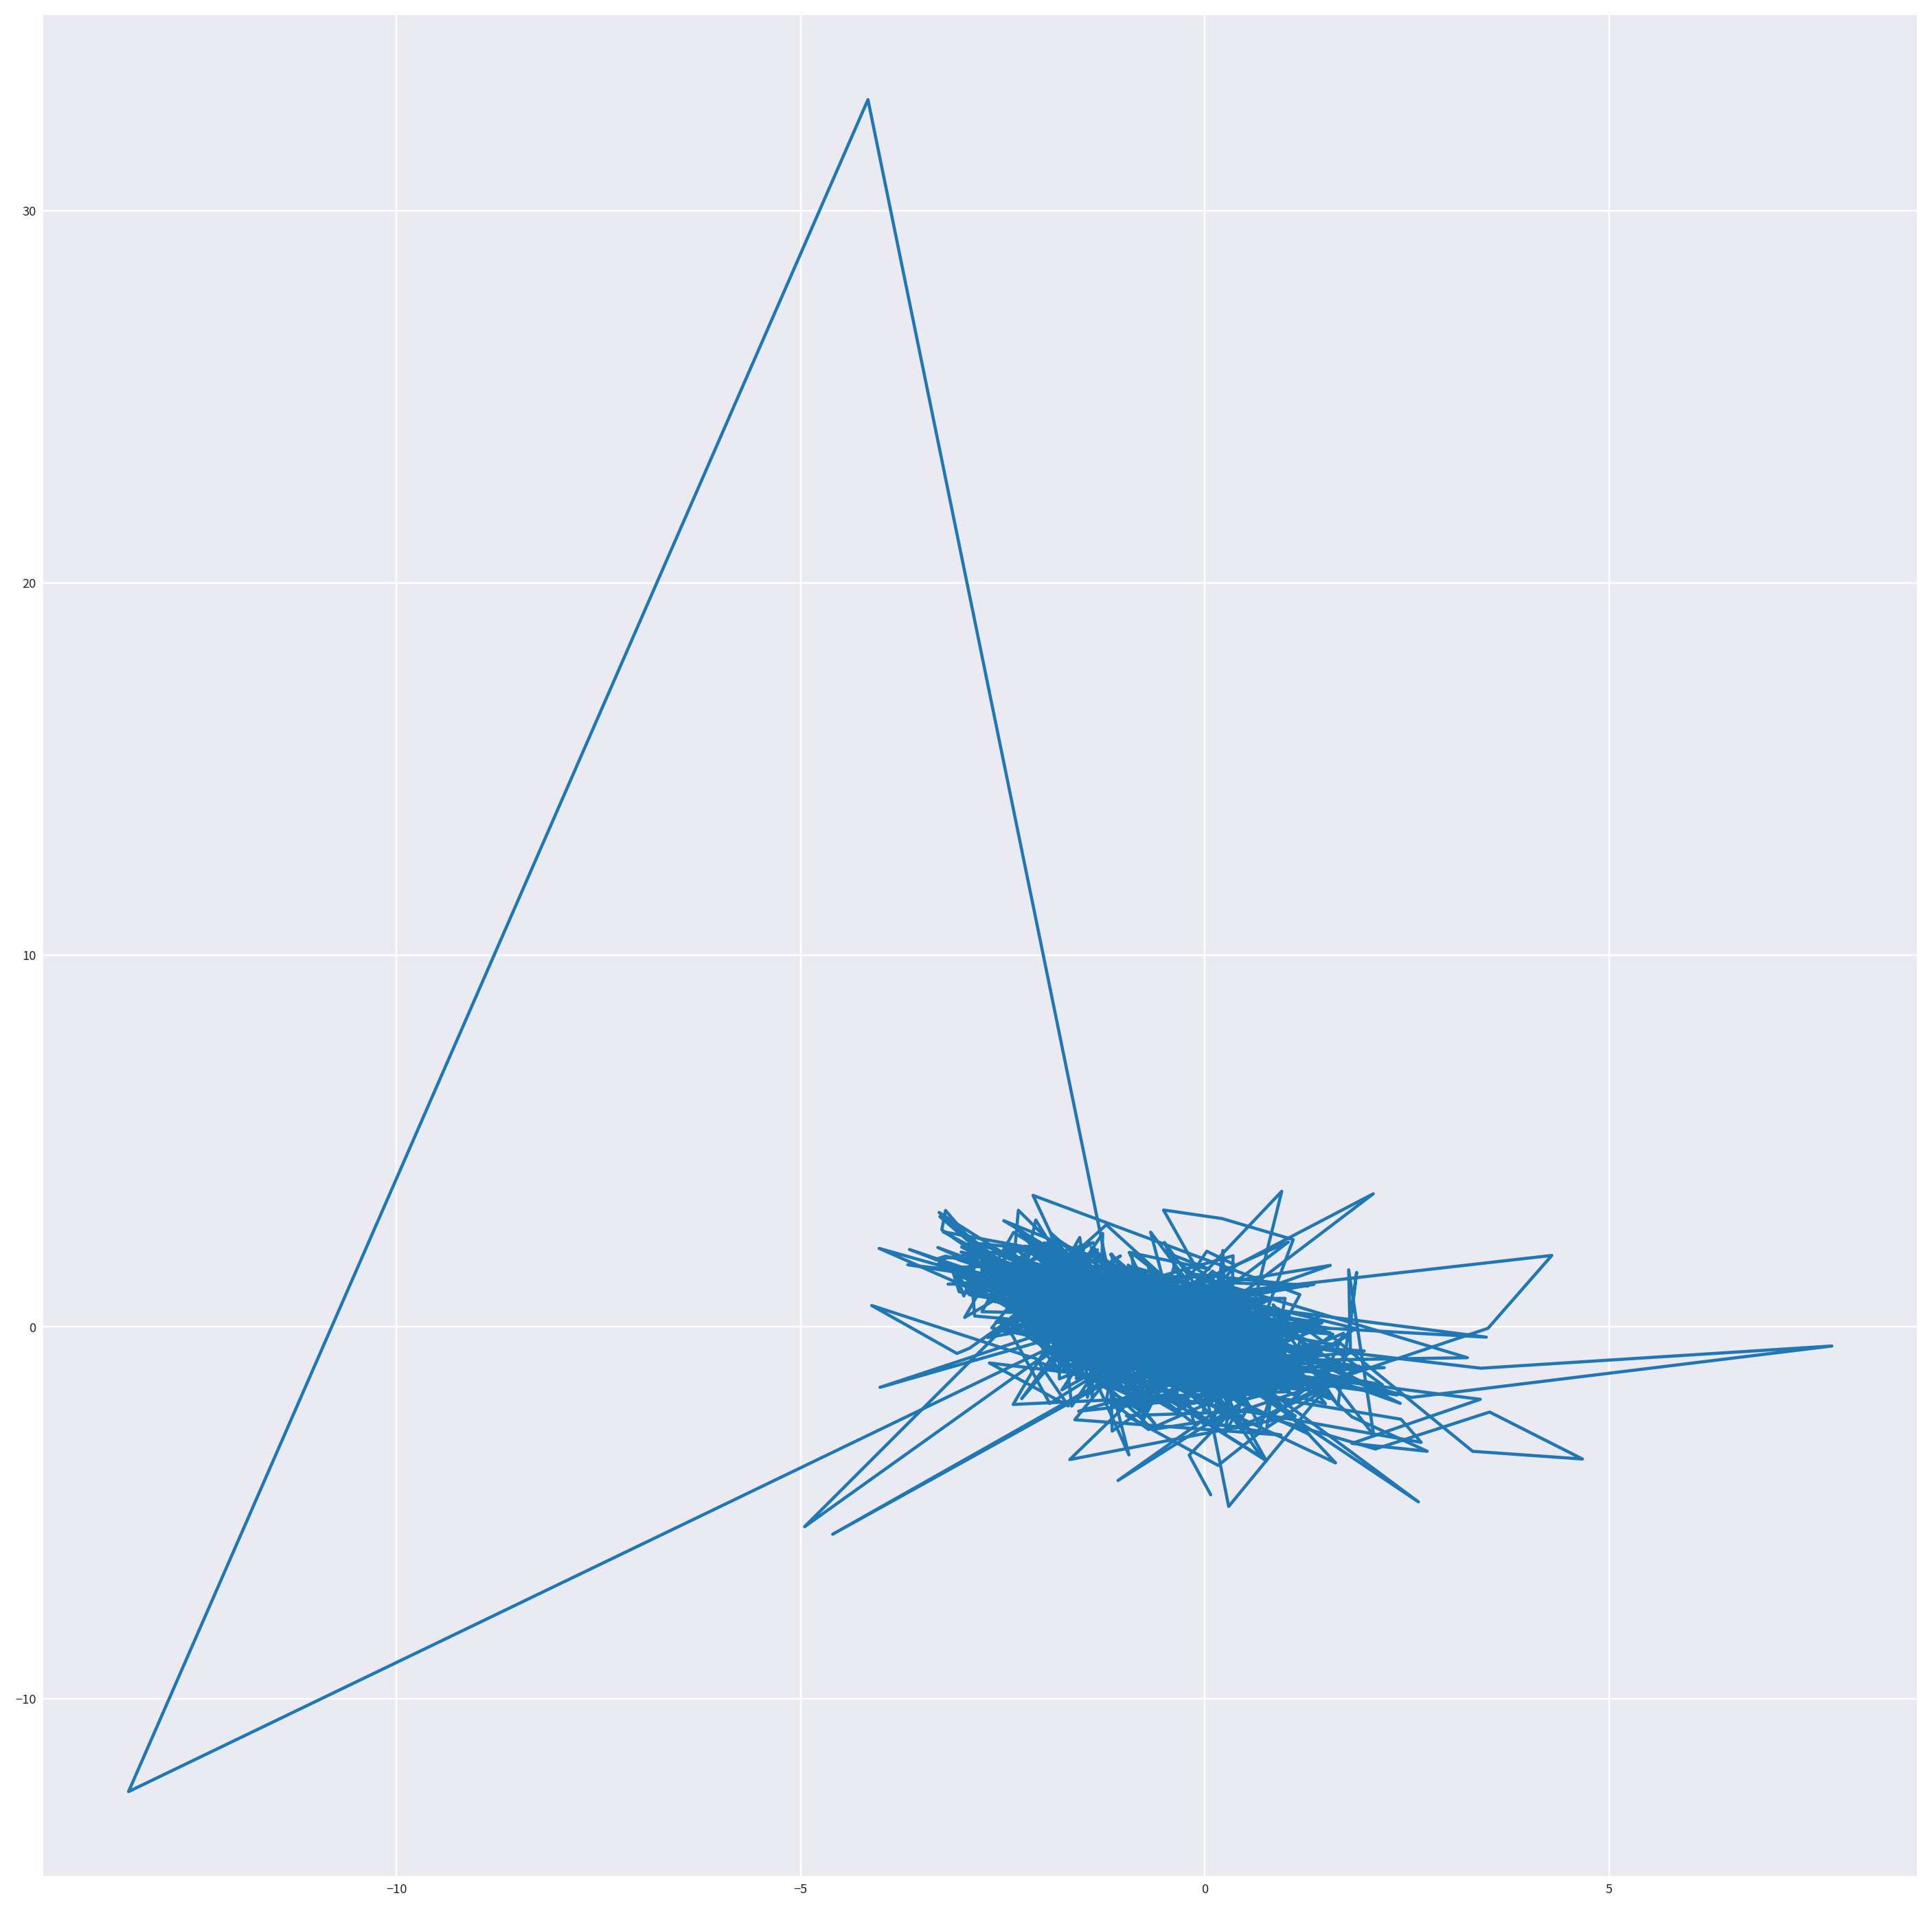

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f78a82c3da0>

In [212]:
s
ort(nmea_df, :time_UTC)


latitude_arr
for i in 1:0
    println((train_df_.lngDeg[i] - longitude_arr[i])*1000*111)
    
    println(train_df_.lngDeg[i])
    println(longitude_arr[i])
end
minimum((train_df_.lngDeg .- longitude_arr)*1000*111)
fig, ax = plt.subplots()
latitude_delta = latitude_arr - train_df_.latDeg
longitude_delta = longitude_arr - train_df_.lngDeg
ax.plot(latitude_delta* 1000*111, longitude_delta* 1000*111) 
#ax.scatter(train_df_.latDeg, train_df_.lngDeg, s =0.1)

In [158]:
train_df_ = train_df[(train_df.phone .== "2020-05-14-US-MTV-1_Pixel4"),:]
train_df_[!, :time_UTC] = millisSinceGpsEpoch_to_UnixTime.(train_df_.millisSinceGpsEpoch)
train_df_

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,time_UTC
,String,String,Int64,Float64,Float64,Float64,String,DateTime
1,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.4236,-122.094,-34.06,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:45.442
2,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.4236,-122.094,-33.29,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:46.442
3,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.4236,-122.094,-30.99,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:47.442
4,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.4236,-122.094,-32.83,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:48.442
5,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.4236,-122.094,-34.49,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:49.442
6,2020-05-14-US-MTV-1,Pixel4,1273529468442,37.4236,-122.094,-33.57,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:50.442
7,2020-05-14-US-MTV-1,Pixel4,1273529469442,37.4236,-122.094,-33.52,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:51.442
8,2020-05-14-US-MTV-1,Pixel4,1273529470442,37.4236,-122.094,-31.6,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:52.442
9,2020-05-14-US-MTV-1,Pixel4,1273529471442,37.4236,-122.094,-34.22,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:53.442


In [133]:
df_sample_trail = CSV.read("../train/2020-05-14-US-MTV-1/Pixel4/Pixel4_derived.csv", DataFrame)
df_sample_trail_gt = CSV.read("../train/2020-05-14-US-MTV-1/Pixel4/ground_truth.csv", DataFrame)
display(first(df_sample_trail, 40))
display(first(df_sample_trail_gt, 10))

cols = propertynames(df_sample_trail)
ncols = length(cols)
fig, ax = plt.subplots(ncols, 1, figsize=(6, 3*ncols))
for (i, col) in enumerate(cols)
    ax[i,1].hist(df_sample_trail[!, col], bins=40)
    ax[i,1].set_title(String(col))
end
    

,collectionName,phoneName,millisSinceGpsEpoch,constellationType,svid,signalType,receivedSvTimeInGpsNanos,xSatPosM,ySatPosM,zSatPosM,xSatVelMps,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM
,String,String,Int64,Int64,Int64,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,3,24,GLO_G1,1273529463363061857,-2.5399e7,-6.92512e5,-2.28043e6,-325.826,156.04,3559.76,-468.084,0.001,2.3795e7,11.992,1134.76,10.866,16.647
2,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,13,GAL_E1,1273529463363970742,-5.19989e6,-1.74193e7,2.33613e7,2239.3,700.815,1022.01,1.20171e5,0.0,2.35225e7,1.799,-222.675,3.946,2.717
3,2020-05-14-US-MTV-1,Pixel4,1273529464442,1,5,GPS_L1,1273529463365539137,-2.17986e6,-2.61549e7,-3.43769e6,325.541,-419.725,3129.01,-3793.07,-0.001,2.30523e7,4.197,0.0,7.554,5.704
4,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,15,GAL_E1,1273529463352380595,1.63547e7,-1.04783e7,2.23446e7,2172.41,561.971,-1326.0,2.59937e5,-0.0,2.69971e7,8.094,-222.675,7.968,9.151
5,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,21,GAL_E1,1273529463364075083,-1.48404e7,-2.11096e7,1.44963e7,-426.094,-1395.67,-2467.79,-179556.0,-0.001,2.34912e7,2.698,-222.675,3.834,2.544
6,2020-05-14-US-MTV-1,Pixel4,1273529464442,1,24,GPS_L5,1273529463365097689,-2.19259e7,-1.49933e7,-3.43824e6,513.288,-81.804,-3058.1,-3909.92,0.001,2.31847e7,1.199,-2352.94,13.109,5.307
7,2020-05-14-US-MTV-1,Pixel4,1273529464442,3,22,GLO_G1,1273529463375230627,-3.20921e6,-1.04993e7,2.30146e7,3150.57,209.727,546.442,-377.065,-0.001,2.01469e7,5.696,1134.76,4.294,3.138
8,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,27,GAL_E1,1273529463355958821,-4.07358e6,-2.90569e7,-3.92551e6,-28.481,411.162,-3013.65,65954.4,-0.002,2.59244e7,3.897,-222.675,7.111,5.174
9,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,26,GAL_E5A,1273529463364807825,-2.38646e7,-1.41943e7,1.02543e7,953.292,405.376,2780.57,956095.0,-0.013,2.32716e7,1.199,-2350.5,8.247,3.106


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree
,String,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.4236,-122.094,33.21,551.44,1.1,0.0,0.0,12.7
2,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.4236,-122.094,33.21,552.44,1.1,0.0,0.0,12.7
3,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.4236,-122.094,33.21,553.44,1.1,0.0,0.0,12.7
4,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.4236,-122.094,33.2,554.44,1.1,0.0,0.0,12.7
5,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.4236,-122.094,33.2,555.44,1.1,0.0,0.0,12.7
6,2020-05-14-US-MTV-1,Pixel4,1273529468442,37.4236,-122.094,33.2,556.44,1.1,0.0,0.0,12.7
7,2020-05-14-US-MTV-1,Pixel4,1273529469442,37.4236,-122.094,33.19,557.44,1.1,0.0,0.0,12.7
8,2020-05-14-US-MTV-1,Pixel4,1273529470442,37.4236,-122.094,33.19,558.44,1.1,0.0,0.0,12.7
9,2020-05-14-US-MTV-1,Pixel4,1273529471442,37.4236,-122.094,33.19,559.44,1.1,0.0,0.0,12.7


LoadError: [91mUndefVarError: subplots not defined[39m

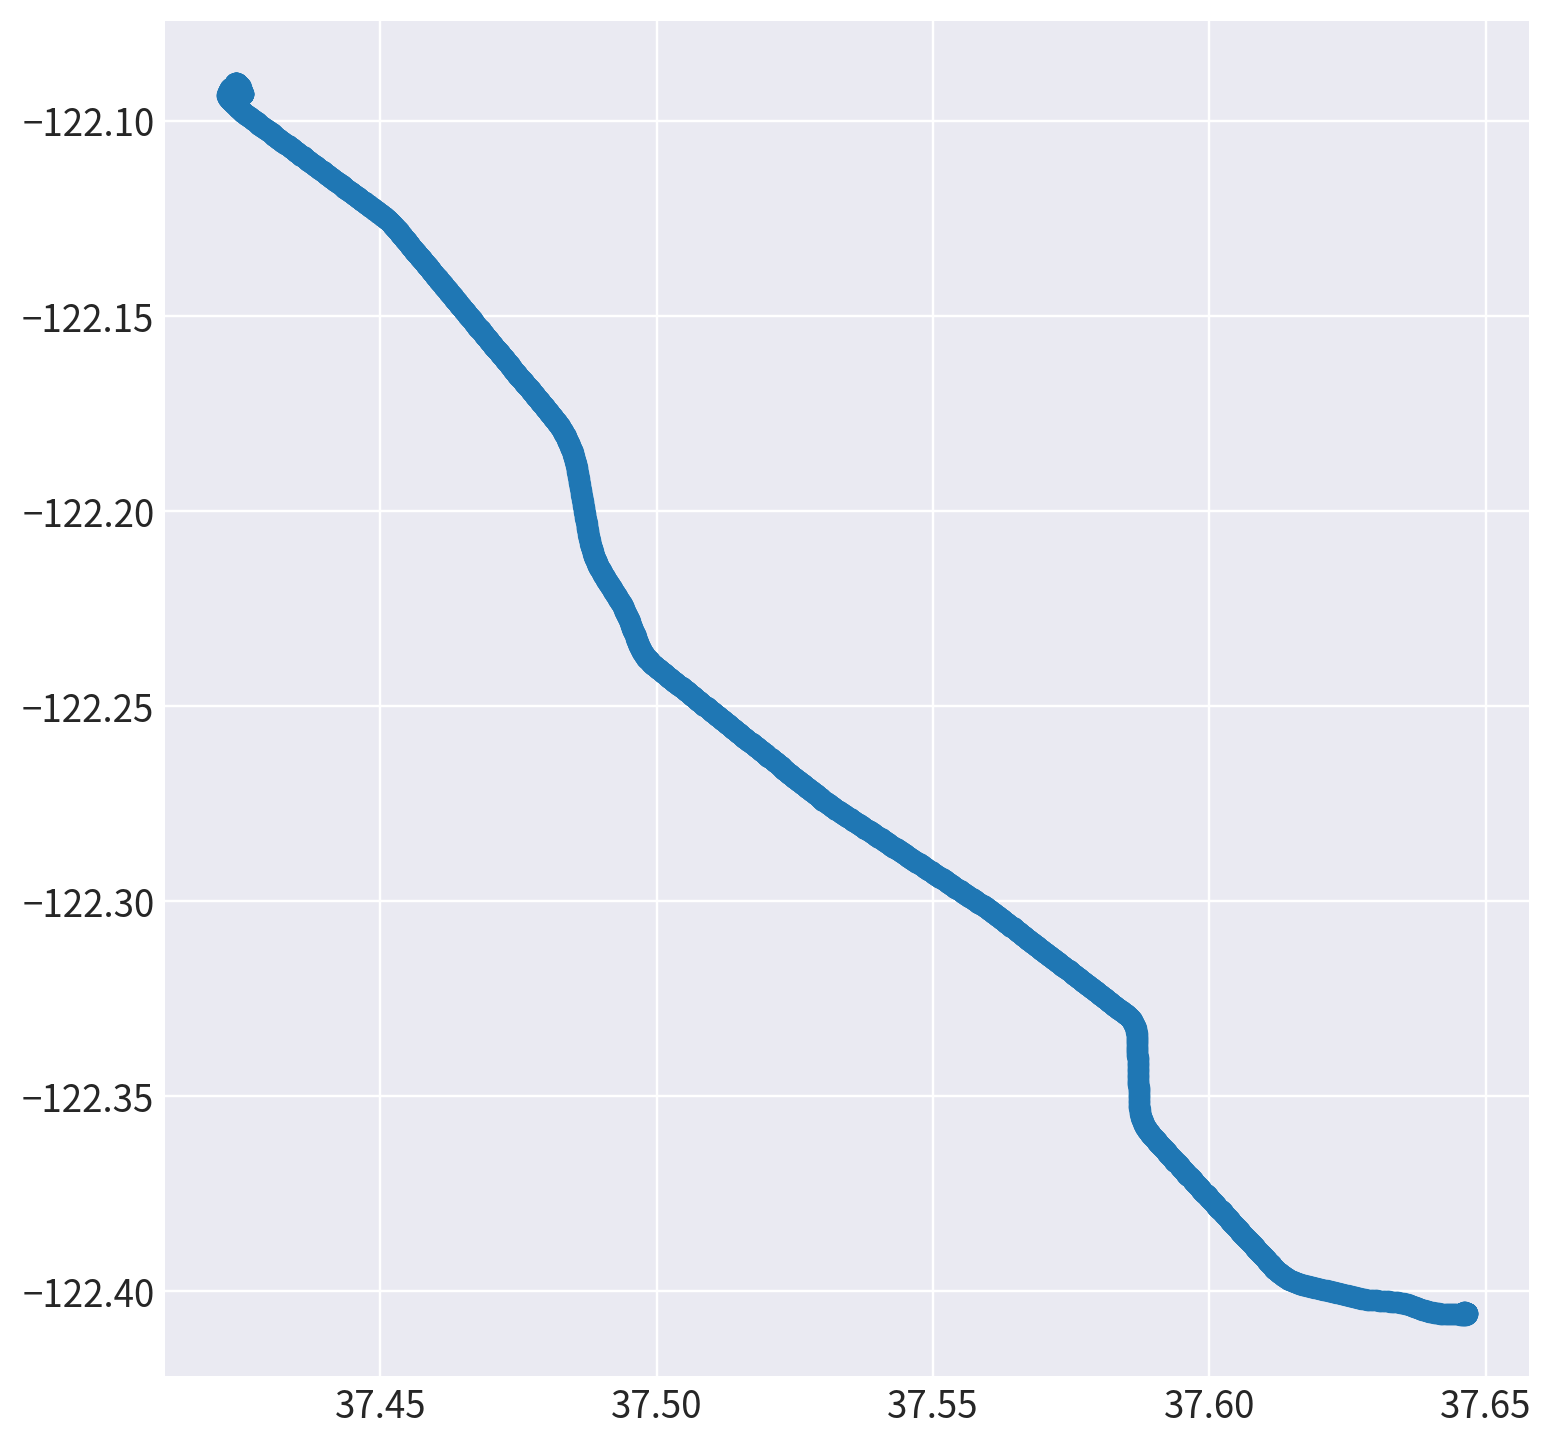

PyObject <matplotlib.collections.PathCollection object at 0x7f52f3c43128>

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df_sample_trail_gt[!, :latDeg], df_sample_trail_gt[!, :lngDeg])

In [58]:
dataline = "# UncalAccel,utcTimeMillis,elapsedRealtimeNanos,UncalAccelXMps2,UncalAccelYMps2,UncalAccelZMps2"
 is_header = first(dataline) == '#'
dataline = strip(dataline, ['#', ' ']) |> x -> split(x, ',')  |> collect# skip over notes, version numbers, etc
section_name = dataline[1]
if  section_name in  gnss_section_names
    if is_header
        println(section_name)
    end
end
section_name
a = []
append!(a, [1,2,3])

UncalAccel


3-element Array{Any,1}:
 1
 2
 3

In [24]:
    gnss_section_names = ["Raw","UncalAccel", "UncalGyro", "UncalMag", "Fix", "Status", "OrientationDeg"]
    gnss_map = Dict([k => [] for k in gnss_section_names])
for k in keys(gnss_map)
    @show(k)
    v = gnss_map[k]
    @show(v)
end

k = "UncalAccel"
v = Any[]
k = "Fix"
v = Any[]
k = "Raw"
v = Any[]
k = "UncalGyro"
v = Any[]
k = "Status"
v = Any[]
k = "UncalMag"
v = Any[]
k = "OrientationDeg"
v = Any[]


In [48]:
first("ertyuik") == 'e'

true